In [1]:
import os
import pickle
import datetime
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
# import dill
import json

In [3]:
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [4]:
import google.colab
from google.colab import files

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**a)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**b)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**c)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**d)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                # ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12999554.48it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200289.09it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3933190.47it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8311115.09it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [7]:
trainset = trainset_orig
testset = testset_orig

In [8]:
# len(trainset),len(testset),len(validset)

In [9]:
len(trainset),len(testset)

(60000, 10000)

In [10]:
i = np.random.randint(len(trainset))
print(f"i={i}")
image,label = trainset[i]

i=6591


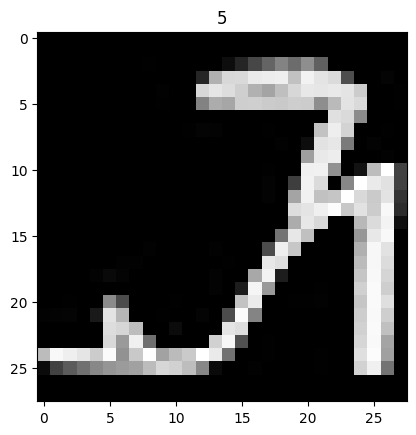

In [11]:
# Graficamos la imagen
plt.title(str(label))
plt.imshow(image.squeeze(),cmap="Greys_r")

In [12]:
# Creamos un diccionario con los labels de los elementos

labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

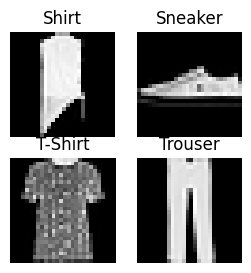

In [13]:
figure = plt.figure(figsize = (3,3))
cols,rows = 2,2
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**a)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**b)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.

In [14]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

In [15]:
# 3.b)
# Convertimos FashionMNIST Dataset a CustomDataset para
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)

## Ejercicio 4) Red Neuronal Autoencoder

**a)** Cree una red neuronal de 2 capas, una oculta de $n$ neuronas y las de entrada y salida de $28\times 28=784$ neuronas.
En la capa intermedia y la de salida utilice neuronas tipo ReLU.
Las capas sucesivas tienen que estar totalmente conectadas entre si.
Agregue un dropout de 0.2.

**b)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo sin entrenar.

In [33]:
# Definimos el autoencoder con parámetros de entrada la cantidad
# de neuronas de la capa oculta y el porcentaje de dropout
class Autoencoder(nn.Module):
    def __init__(self,n,p):
        super(Autoencoder, self).__init__()
        # "Achatamos" la matriz de 28x28 píxeles,
        # transformandola en un vector de 784 elementos
        self.flatten = nn.Flatten()
        # Procedimiento que aplica la red
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,n),
            nn.ReLU(),
            nn.Dropout(p),
        )
        self.decoder = nn.Sequential(
            nn.Linear(n,28*28),
            nn.ReLU(),
        )

        # self.linear_relu_stack = nn.Sequential(
        #     # Aplica una tranformacion lineal de un vector
        #     # con longitud 28*28 a uno con n
        #     nn.Linear(28*28,n),
        #     # Aplicamos una ReLu al vector
        #     nn.ReLU(),
        #     # Se apagan de manera aleatoria algunas neuronas
        #     # con probabilidad p
        #     nn.Dropout(p),
        #     # Ahora aplicamos la tranformación inversa para
        #     # poder reconstruir la imagen
        #     nn.Linear(n,28*28),
        #     nn.ReLU(),

        # )
    # Se aplica el procediento
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
# Creamos el modelo
n = 64
p = 0.1
#model = NeuralNetwork(n)
model = Autoencoder(n,p)

RuntimeError: ignored

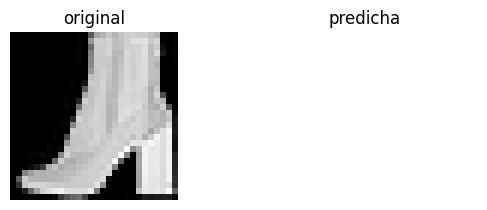

In [35]:
# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure()
rows,cols = 2,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    # image_pred = model.imagen(image)
    image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
plt.show()

In [ ]:
device

'cuda'

## Ejercicio 5) Entrenando el modelo

**a)** Implemente, en una función, un loop de entrenamiento que recorra los batchs.

**b)** Implemente, en una función, un loop de testeo que recorra los batchs.

**c)** Defina el rate de entrenamiento y el tamaño de los batchs en $10^{-3}$ y $1000$ respectivamente.

**d)** Inicialize los `DataLoaders` nuevamente.

**e)** Cree una función de pérdida usando la MSE-Loss y un optimizador.
Pruebe con el SGD y ADAM.

**f)** Implemente un loop de entrenamiento y testeo que recorra un numero arbitrario de épocas.
Este loop debe guardar en respectivas listas los valores de los promedios de la MSE-Loss sobre el conjunto de entrenamiento y el de testeo.

**g)** Use las listas del inciso anterior para graficar en función de las épocas la MSE-Loss de entrenamiento y la MSE-Loss de testeo.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**h)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

In [21]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch*batch_size % 5000 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    #frac_correct = sum_correct/size
    #print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

In [23]:
# Definimos
learning_rate = 1e-3
batch_size = 1000

In [24]:
# Creamos los DataLoaders
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

In [25]:
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fn = nn.CrossEntropyLoss() # Para clasificación
loss_fn = nn.MSELoss() # Para autoencoder
# y un optimizador, un Stochastic Gradient Descent, en este caso.
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# o, alternativamente, un optimizador tipo ADAM.
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

Red con 512 neuronas en la capa intermedia
------------------------------
Epoch 1
-------------------------------
batch=0 loss=0.188418  muestras-procesadas:[    0/50000]
batch=5 loss=0.138355  muestras-procesadas:[ 5000/50000]
batch=10 loss=0.113633  muestras-procesadas:[10000/50000]
batch=15 loss=0.105177  muestras-procesadas:[15000/50000]
batch=20 loss=0.088188  muestras-procesadas:[20000/50000]
batch=25 loss=0.077295  muestras-procesadas:[25000/50000]
batch=30 loss=0.070291  muestras-procesadas:[30000/50000]
batch=35 loss=0.064444  muestras-procesadas:[35000/50000]
batch=40 loss=0.058867  muestras-procesadas:[40000/50000]
batch=45 loss=0.056055  muestras-procesadas:[45000/50000]
Test Error: Avg loss: 0.051101 

Test Error: Avg loss: 0.050728 

Epoch 2
-------------------------------
batch=0 loss=0.052945  muestras-procesadas:[    0/50000]
batch=5 loss=0.052335  muestras-procesadas:[ 5000/50000]
batch=10 loss=0.047959  muestras-procesadas:[10000/50000]
batch=15 loss=0.047139  muestr

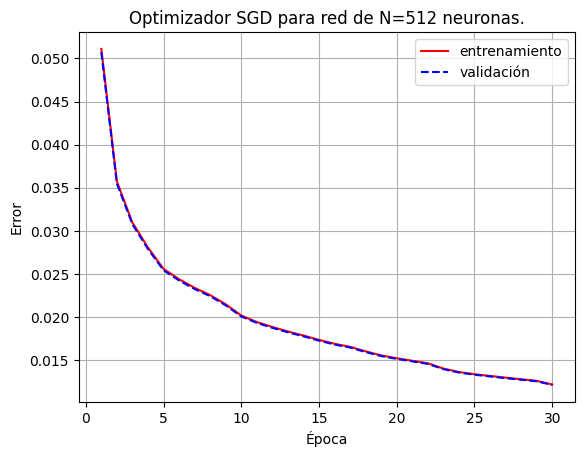

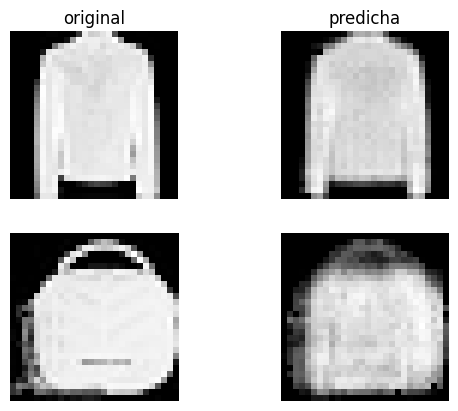

Done!


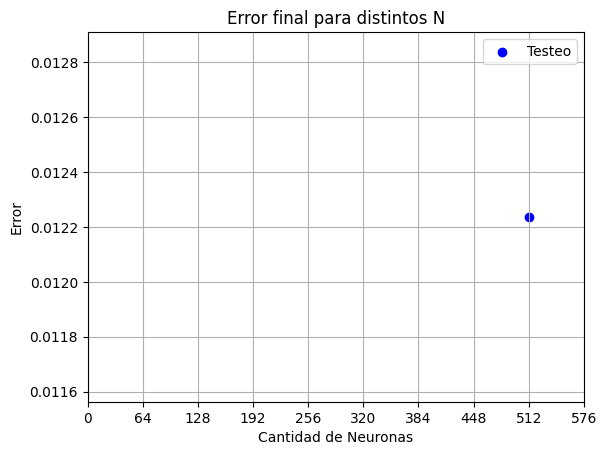

In [36]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_avg_train_loss = []
list_avg_test_train_loss = []
list_avg_test_loss = []
error_testeo = []

N = [512]

# loss_fn = nn.MSELoss() # Para autoencoder

for n in N:

   model = Autoencoder(n,0.1)

   temp_avg_train_loss      = []
   temp_avg_test_train_loss = []
   temp_avg_test_loss       = []

   train_data, val_data = random_split(trainset, [50000, 10000])

   train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
   val_loader   = DataLoader(val_data, batch_size   = batch_size, shuffle = True)

   print('Red con '+str(n)+' neuronas en la capa intermedia\n------------------------------')
   for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")


      # El tipo de método que usamos para optimizar la red
      # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
      optimizer = torch.optim.SGD(model.parameters(),lr=0.5,momentum=0.9)


      avg_train_loss      = train_loop(train_loader,model,loss_fn,optimizer)
      avg_test_train_loss = valid_loop(train_loader,model,loss_fn)
      avg_test_loss       = valid_loop(val_loader,model,loss_fn)

      list_avg_train_loss.append(avg_train_loss)
      list_avg_test_train_loss.append(avg_test_train_loss)
      list_avg_test_loss.append(avg_test_loss)

      temp_avg_train_loss.append(avg_train_loss)
      temp_avg_test_train_loss.append(avg_test_train_loss)
      temp_avg_test_loss.append(avg_test_loss)

  # Calculamos los errores en datos que nunca vió la Red
   test_loss       = valid_loop(testloader,model,loss_fn)
   error_testeo.append(test_loss)

 #  Graficamos la evoición del error con las épocas
   plt.xlabel('Época')
   plt.ylabel('Error')
  # plt.xlim(40,50)
  # plt.ylim(0,0.024)
  # plt.plot(list(range(1,len(temp_avg_train_loss)+1)),temp_avg_train_loss,label="train",linestyle='-.',c='green')
   plt.plot(list(range(1,len(temp_avg_test_train_loss)+1)),temp_avg_test_train_loss,label="entrenamiento",linestyle='-',c='red')
   plt.plot(list(range(1,len(temp_avg_test_loss)+1)),temp_avg_test_loss,label="validación",linestyle='--',c='blue')
   plt.title('Optimizador SGD para red de N='+str(n)+' neuronas.')
   plt.grid()
   plt.legend()
   plt.show()

   # Miramos que imagenes predice el modelo entrenado
   figure = plt.figure()
   rows,cols = 2,2
   i = 0 # subplot index
   model.eval()
   for row in range(1,rows+1):
       j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
       # Ploteamos la imagen original
       i += 1
       image,flatten_imagen = testset[j]
       figure.add_subplot(rows,cols,i)
       if row==1:
         plt.title("original")
       plt.axis("off")
       plt.imshow(image.squeeze(),cmap="Greys_r")
       # Ploteamos la imagen predicha
       i += 1
       figure.add_subplot(rows,cols,i)
       if row==1:
         plt.title("predicha")
       plt.axis("off")
       #image_pred = model.imagen(image)
       #plt.imshow(image_pred,cmap="Greys_r")
       with torch.no_grad(): #
           image_gpu = image.to(device)
       pred_gpu = model(image_gpu)
       pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
       plt.imshow(pred_cpu,cmap="Greys_r")
   plt.show()

print("Done!")


fig,ax = plt.subplots()

plt.xlabel('Cantidad de Neuronas')
plt.ylabel('Error')
# Ploteamos el error global para los distintos tamaños de la red oculta
plt.scatter(N,error_testeo,label="Testeo",c='b')
ax.set_xticks(range(0,512+2*64,64))
# ax.set_xticklabels(N)
# plt.plot(list(range(1,len(temp_avg_test_loss)+1)),temp_avg_test_loss,label="validación",linestyle='--',c='blue')
plt.title('Error final para distintos N')
plt.grid()
plt.legend()
plt.show()


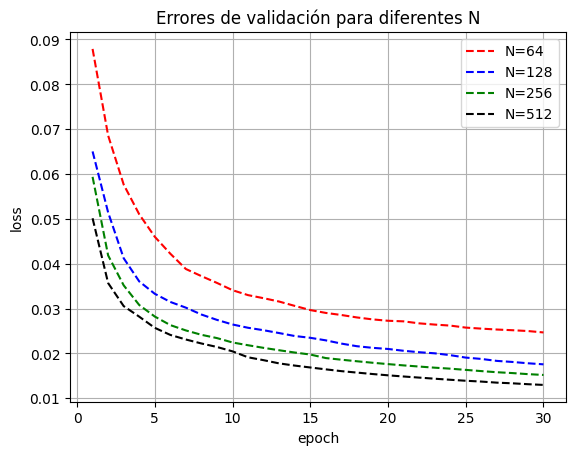

In [ ]:
# lista original
loss_entrenamiento = list_avg_test_train_loss

loss_validacion    = list_avg_test_loss

# Número de elementos por sublista
tamano_sublista = num_epochs

# Dividir la lista en sublistas de 30 elementos
entrenamiento_loss = [loss_entrenamiento[i:i+tamano_sublista] for i in range(0, len(loss_entrenamiento), tamano_sublista)]

validacion_loss   =  [loss_validacion[i:i+tamano_sublista] for i in range(0, len(loss_validacion), tamano_sublista)]

# # Imprimir las sublistas
# for sublista in validacion_loss:
#     print(sublista)


# type(sublista)

plt.xlabel('Época')
plt.ylabel('Pérdida')
# plt.xlim(40,50)
# plt.ylim(0,0.024)
plt.title('Errores de validación para diferentes N')

# plt.plot(list(range(1,len(entrenamiento_loss[0])+1)),entrenamiento_loss[0],label="entrenamiento",linestyle='-',c='red')
plt.plot(list(range(1,len(validacion_loss[0])+1)),validacion_loss[0],label="N=64",linestyle='--',c='red')

# plt.plot(list(range(1,len(entrenamiento_loss[1])+1)),entrenamiento_loss[1],label="entrenamiento",linestyle='-',c='blue')
plt.plot(list(range(1,len(validacion_loss[1])+1)),validacion_loss[1],label="N=128",linestyle='--',c='blue')

# plt.plot(list(range(1,len(entrenamiento_loss[2])+1)),entrenamiento_loss[2],label="entrenamiento",linestyle='-',c='g')
plt.plot(list(range(1,len(validacion_loss[2])+1)),validacion_loss[2],label="N=256",linestyle='--',c='g')

# plt.plot(list(range(1,len(entrenamiento_loss[3])+1)),entrenamiento_loss[3],label="entrenamiento",linestyle='-',c='k')
plt.plot(list(range(1,len(validacion_loss[3])+1)),validacion_loss[3],label="N=512",linestyle='--',c='k')

plt.grid()
plt.legend()
plt.show()

In [37]:
error_testeo

[0.012236338295042514]

In [38]:
# Saving model
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('Autoencoder_n_512_p_01_epocas_30_TP.pt') # Save

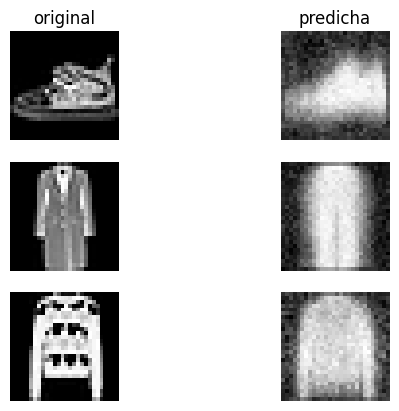

In [ ]:
 # Miramos que imagenes predice el modelo entrenado
# 5.h)
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
model.eval()
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): #
        image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
plt.show()

In [ ]:
for n in N:
  print(n)

64
128


In [ ]:
for name,param in model.named_parameters():
  print(name,param)

linear_relu_stack.0.weight Parameter containing:
tensor([[ 0.0779,  0.0562,  0.0409,  ..., -0.0022,  0.0132,  0.0163],
        [ 0.0477,  0.0377, -0.0252,  ...,  0.0020,  0.0316, -0.0469],
        [-0.0010, -0.0126,  0.0274,  ..., -0.0027,  0.0292, -0.0144],
        ...,
        [-0.0295, -0.0084, -0.0290,  ...,  0.0021,  0.0239,  0.0117],
        [ 0.0133, -0.0556, -0.1203,  ..., -0.0078, -0.0198,  0.0114],
        [ 0.0016,  0.0099, -0.0635,  ...,  0.0579,  0.0050, -0.0334]],
       requires_grad=True)
linear_relu_stack.0.bias Parameter containing:
tensor([-0.0804, -0.1154, -0.0261, -0.0148, -0.0293, -0.1220, -0.0406, -0.0286,
         0.1362, -0.1299, -0.0012, -0.0808, -0.0411,  0.1003, -0.0227, -0.0597,
         0.1413, -0.0245, -0.1055, -0.0285,  0.1414, -0.0216, -0.1173, -0.0240,
         0.0136, -0.0295,  0.0984,  0.0053,  0.1386, -0.0174, -0.1098,  0.1536,
         0.2616, -0.0223, -0.0172,  0.0336,  0.0190, -0.0708, -0.0548, -0.0718,
         0.0132, -0.0562, -0.1066, -0.1398,

# Lo que pide el TP

In [ ]:
import os
import pickle
import datetime
from collections import defaultdict

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json

In [ ]:
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

In [ ]:
import google.colab
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# Creamos una Red con una capa oculta

class Autoencoder(nn.Module):
    def __init__(self,n,p):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Dropout(p),
            nn.Linear(28*28,n),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n,28*28),
            # nn.ReLU(),
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [ ]:
#  Descargamos los dataset

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)


# Definimos el set de entrenamiento y el de prueba

trainset = trainset_orig
testset = testset_orig


# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label


# Convertimos FashionMNIST Dataset a CustomDataset para
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)

100%|██████████| 26421880/26421880 [00:01<00:00, 18091141.99it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 329042.18it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5412148.95it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16712288.69it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
# Creamos el modelo
n = 64
p = 0.1
#model = NeuralNetwork(n)
model = Autoencoder(n,p)

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch*batch_size % 5000 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    #frac_correct = sum_correct/size
    #print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

In [ ]:
# Definimos
learning_rate = 1e-3
batch_size = 1000

In [ ]:
# Creamos los DataLoaders
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

In [ ]:
trainloader

In [ ]:
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fn = nn.CrossEntropyLoss() # Para clasificación
loss_fn = nn.MSELoss() # Para autoencoder
# y un optimizador, un Stochastic Gradient Descent, en este caso.
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# o, alternativamente, un optimizador tipo ADAM.
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_avg_train_loss = []
list_avg_test_train_loss = []
list_avg_test_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
    avg_test_train_loss = test_loop(trainloader,model,loss_fn)
    avg_test_loss = test_loop(testloader,model,loss_fn)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_test_train_loss.append(avg_test_train_loss)
    list_avg_test_loss.append(avg_test_loss)
print("Done!")

Epoch 1
-------------------------------
batch=0 loss=0.227777  muestras-procesadas:[    0/60000]
batch=5 loss=0.192785  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.171238  muestras-procesadas:[10000/60000]
batch=15 loss=0.144574  muestras-procesadas:[15000/60000]
batch=20 loss=0.119922  muestras-procesadas:[20000/60000]
batch=25 loss=0.101883  muestras-procesadas:[25000/60000]
batch=30 loss=0.090790  muestras-procesadas:[30000/60000]
batch=35 loss=0.080751  muestras-procesadas:[35000/60000]
batch=40 loss=0.075598  muestras-procesadas:[40000/60000]
batch=45 loss=0.072591  muestras-procesadas:[45000/60000]
batch=50 loss=0.070484  muestras-procesadas:[50000/60000]
batch=55 loss=0.065050  muestras-procesadas:[55000/60000]
Test Error: Avg loss: 0.063722 

Test Error: Avg loss: 0.063404 

Epoch 2
-------------------------------
batch=0 loss=0.064213  muestras-procesadas:[    0/60000]
batch=5 loss=0.062510  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.058115  muestras-procesadas:[1

KeyboardInterrupt: ignored

In [ ]:
plt.xlabel('Epoca')
plt.ylabel('Error')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)
# plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label="train",linestyle='-.',c='green')
plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_train_loss,label="entrenamiento",linestyle='-',c='magenta')
plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_loss,label="validación",linestyle='--',c='blue')
plt.title('')
plt.legend()
plt.grid()
# plt.savefig("SGD_epocas_1000_n_64.png")
plt.show()

In [ ]:
 # Miramos que imagenes predice el modelo entrenado

figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): #
        image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
# plt.savefig("SGD_epocas_1000_n_64_figuras.png")
plt.show()

# -----------------------------------------------------------------------

In [ ]:
# Imports básicos
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch as tr
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## FashionMNIST Dataset

Fashion-MNIST es un dataset compilado por una empresa de tecnología en ventas de accesorios de moda. Es un dataset simple, que sigue el mismo espíritu del MNIST de dígitos, pero con un poco más de riqueza en los datos. Tiene 60,000 ejemplos en la particion de entrenamiento y 10,000 en la de test. Cada ejemplo es una imagen de un canal de 28x28, con una etiqueta asociada de 10 clases disponibles.



In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST("mnist-data", train=True,
                   transform=transforms.ToTensor(), download=True)

Lt = int(len(train_data)*.8)
data_classes = train_data.classes
train_data, valid_data = random_split(train_data, [Lt, len(train_data) - Lt])

test_data = FashionMNIST("mnist-data", train=False,
                  transform=transforms.ToTensor(), download=True)
IM_SIZE = (28, 28)

# Dataloaders (para recorrer el dataset y armar lotes)
nbatch = 256
train_loader = DataLoader(train_data, batch_size=nbatch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=nbatch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=False)

# Ejemplos de train
nfig = min(16, nbatch)
for x, y in train_loader:
    fig, ax = plt.subplots(1, nfig, figsize=(25, 5))
    for k in range(nfig):
        ax[k].imshow(x[k,:,:].squeeze().numpy(), cmap="gray")
        ax[k].set_title(f"{data_classes[y[k].item()]}")
        ax[k].axis("off")
    break # solo un batch


## Implementación

Acá implemento el modelo

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

class AE(nn.Module):
    def __init__(self, emb_size, imsize=[28, 28], dropout_prob=0.1, device='cpu'):
        super().__init__()

        nin = imsize[0] * imsize[1]
        self.encoder = nn.Sequential(
            nn.Linear(nin, emb_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
        )

        self.decoder = nn.Sequential(
            nn.Linear(emb_size, nin),
            nn.Sigmoid()
        )

        self.loss_func = nn.MSELoss()
        self.optim = optim.SGD(self.parameters(), lr=1e-3)  # hago el calculo del gradiente SGD
        self.device = device
        self.to(device)
        self.imsize = imsize

    def encode(self, x):
        x = x.view(x.shape[0], -1)
        z = self.encoder(x)
        return z

    def decode(self, z):
        xhat = self.decoder(z)
        xhat = xhat.view(xhat.shape[0], 1, self.imsize[0], self.imsize[1])
        return xhat

    def forward(self, x):
        # Cambiar el modo del modelo dependiendo del modo de ejecución
        if self.training:
            z = self.encode(x)
            xhat = self.decode(z)
        else:
            # Durante la evaluación (validación y prueba), desactivar dropout
            with torch.no_grad():
                self.eval()  # Cambiar a modo de evaluación
                z = self.encode(x)
                xhat = self.decode(z)
                self.train()  # Cambiar de nuevo a modo de entrenamiento

        return xhat

    def fit(self, loader, batch_size, verbose=False):
        epoch_losses = []  # Almacena las pérdidas de cada época
        if verbose:
            loader = tqdm(loader)
        for x, _ in loader:
            x = x.to(self.device)

            self.optim.zero_grad()
            xhat = self(x)
            loss = self.loss_func(xhat, x)
            loss.backward()
            self.optim.step()

        epoch_loss = loss.item()
        epoch_losses.append(epoch_loss)

        return epoch_losses

    def test(self, loader, batch_size):
        epoch_loss = 0
        for x, _ in loader:
            with torch.no_grad():
                x = x.to(self.device)
                xhat = self(x)

            loss = self.loss_func(xhat, x)
            epoch_loss += loss.item()

        return epoch_loss / len(loader)

# Crear una instancia del modelo
net = AE(emb_size=64)

net

## Entrenamiento

Procedo a la parte de entrenamiento del modelo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def train_and_evaluate(hidden_size):
    # Creo la instancia del modelo
    net = AE(emb_size=hidden_size, dropout_prob=0.1)
    nbatch = 1000  # Tamaño del minibatch

    Lt = int(len(train_data) * 0.8)
    train_subset, validation_subset = random_split(train_data, [Lt, len(train_data) - Lt])

    train_loader_subset = DataLoader(train_subset, batch_size=nbatch, shuffle=True)
    validation_loader_subset = DataLoader(validation_subset, batch_size=nbatch, shuffle=False)

    num_epochs = 30
    train_losses = []
    validation_losses = []

    # Entrenamiento
    for epoch in range(num_epochs):
        # Establecer el modelo en modo de entrenamiento
        net.train()
        train_loss = net.fit(train_loader_subset, batch_size=nbatch, verbose=True)
        train_losses.extend(train_loss)

        # Establecer el modelo en modo de evaluación
        net.eval()
        validation_loss = net.test(validation_loader_subset, batch_size=nbatch)
        validation_losses.append(validation_loss)

        print(f"Hidden Size: {hidden_size}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Validation Loss: {validation_loss:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    net.eval()
    test_loss = net.test(test_loader, batch_size=nbatch)
    print(f"Hidden Size: {hidden_size}, Test Loss: {test_loss:.4f}")

# Tamaños de capas ocultas a probar
hidden_sizes = [128, 256, 512]

# Iterar sobre los tamaños de capas ocultas y entrenar/evaluar para cada uno
for hidden_size in hidden_sizes:
    train_and_evaluate(hidden_size)



---



In [ ]:
def train_and_evaluate(hidden_size):
    # Creo la instancia del modelo
    net = AE(emb_size=hidden_size, dropout_prob=0.1)
    nbatch = 1000  # Tamaño del minibatch

    Lt = int(len(train_data) * 0.8)
    train_subset, validation_subset = random_split(train_data, [Lt, len(train_data) - Lt])

    train_loader_subset = DataLoader(train_subset, batch_size=nbatch, shuffle=True)
    validation_loader_subset = DataLoader(validation_subset, batch_size=nbatch, shuffle=False)

    num_epochs = 10
    train_losses = []
    validation_losses = []

    # Entrenamiento
    for epoch in range(num_epochs):
        # Establecer el modelo en modo de entrenamiento
        net.train()
        train_loss = net.fit(train_loader_subset, batch_size=nbatch, verbose=True)
        train_losses.extend(train_loss)

        # Establecer el modelo en modo de evaluación
        net.eval()
        validation_loss = net.test(validation_loader_subset, batch_size=nbatch)
        validation_losses.append(validation_loss)

        print(f"Hidden Size: {hidden_size}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Validation Loss: {validation_loss:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Fase de prueba
    net.eval()
    test_loss = net.test(test_loader, batch_size=nbatch)
    print(f"Hidden Size: {hidden_size}, Test Loss: {test_loss:.4f}")

    return test_loss  # Devolver el error en la fase de prueba

# Tamaños de capas ocultas a probar
hidden_sizes = [128, 256, 512]
test_losses = []  # Almacenar los resultados de la fase de prueba para cada tamaño de capa oculta

# Iterar sobre los tamaños de capas ocultas y entrenar/evaluar para cada uno
for hidden_size in hidden_sizes:
    test_loss = train_and_evaluate(hidden_size)
    test_losses.append(test_loss)

# Comparar los resultados
plt.plot(hidden_sizes, test_losses, marker='o')
plt.xlabel('Hidden Size')
plt.ylabel('Test Loss')
plt.title('Comparison of Test Loss for Different Hidden Sizes')
plt.show()

In [ ]:
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): #
        image_gpu = image.to(device)
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
plt.show()

# Autoencoder Lijandy

#Autocodificadores


In [ ]:
# Imports básicos
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch as tr
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## FashionMNIST Dataset

Fashion-MNIST es un dataset compilado por una empresa de tecnología en ventas de accesorios de moda. Es un dataset simple, que sigue el mismo espíritu del MNIST de dígitos, pero con un poco más de riqueza en los datos. Tiene 60,000 ejemplos en la particion de entrenamiento y 10,000 en la de test. Cada ejemplo es una imagen de un canal de 28x28, con una etiqueta asociada de 10 clases disponibles.



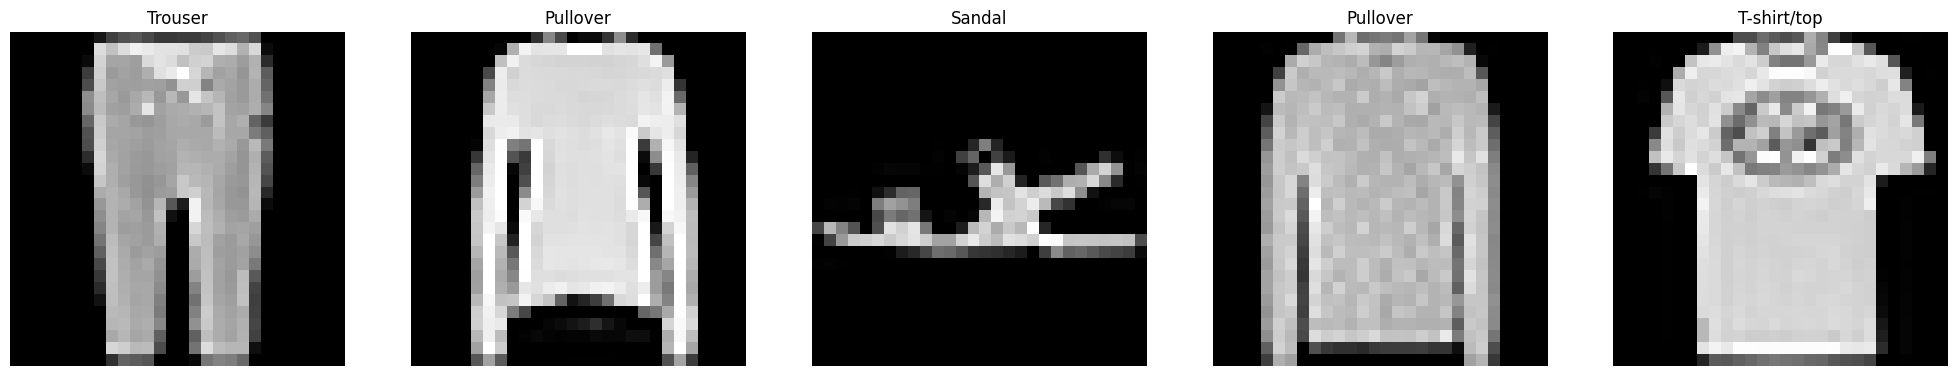

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms



# Descargamos los datos de entrenamiento(que se separan en entrenamiento y validación) y los de testeo
train_data = FashionMNIST("mnist-data", train=True,transform=transforms.ToTensor(), download=True)

test_data = FashionMNIST("mnist-data", train=False,transform=transforms.ToTensor(), download=True)


Lt = int(len(train_data)*.8)
data_classes = train_data.classes
train_data, valid_data = random_split(train_data, [Lt, len(train_data) - Lt])


IM_SIZE = (28, 28)

# Dataloaders (para recorrer el dataset y armar lotes)
nbatch = 256
train_loader = DataLoader(train_data, batch_size=nbatch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=nbatch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=False)

# Ejemplos de train
nfig = min(5, nbatch)
for x, y in train_loader:
    fig, ax = plt.subplots(1, nfig, figsize=(25, 5))
    for k in range(nfig):
        ax[k].imshow(x[k,:,:].squeeze().numpy(), cmap="gray")
        ax[k].set_title(f"{data_classes[y[k].item()]}")
        ax[k].axis("off")
    break # solo un batch


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

# Definir la clase Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 28 * 28),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_autoencoder(hidden_size):
    entrenamiento_data = FashionMNIST("mnist-data", train=True, transform=transforms.ToTensor(), download=True)
    train_size = 50000
    val_size = 10000
    # train_data, val_data = random_split(train_data, [train_size, val_size])

    #Datos que nunca ve la red
    test_data = FashionMNIST("mnist-data", train=False,transform=transforms.ToTensor(), download=True)
    test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=False)

    # Dataloaders
    batch_size = 1000  # Tamaño del minibatch
    # train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Definir el modelo Autoencoder
    autoencoder = Autoencoder(hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(autoencoder.parameters(),lr=0.1, momentum=0.9)


    num_epochs = 15
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # train_size = 50000
        # val_size = 10000
        train_data, val_data = random_split(entrenamiento_data, [train_size, val_size])

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        autoencoder.train()
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

# Errores de entrenamiento
        autoencoder.eval()
        with torch.no_grad():
            train_loss = 0.0
            for data in train_loader:
                train_inputs, _ = data
                train_inputs = train_inputs.view(train_inputs.size(0), -1)
                train_outputs = autoencoder(train_inputs)
                train_loss += criterion(train_outputs, train_inputs).item()

        average_train_loss = train_loss / len(train_loader)

# Errores de validación
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                val_inputs, _ = data
                val_inputs = val_inputs.view(val_inputs.size(0), -1)
                val_outputs = autoencoder(val_inputs)
                val_loss += criterion(val_outputs, val_inputs).item()


        average_val_loss = val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)


    torch.save(autoencoder.state_dict(), f'autoencoder_model_hidden_{hidden_size}.pt')
    print(f'Modelo guardado para capa oculta de tamaño {hidden_size}')

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

# Imagenes de validación
    autoencoder.eval()
    with torch.no_grad():
        for data in val_loader:
            val_inputs, _ = data
            val_inputs = val_inputs.view(val_inputs.size(0), -1)
            val_outputs = autoencoder(val_inputs)
            break

    nfig = min(2, batch_size)
    fig, ax = plt.subplots(2, nfig, figsize=(10, 5))
    for k in range(nfig):
        ax[0, k].imshow(val_inputs[k, :].view(28, 28).numpy(), cmap="gray")
        ax[0, k].set_title("Original")
        ax[0, k].axis("off")

        ax[1, k].imshow(val_outputs[k, :].view(28, 28).numpy(), cmap="gray")
        ax[1, k].set_title("Reconstrucción")
        ax[1, k].axis("off")

# Imagenes para datos nunca vistos por la red

    autoencoder.eval()
    with torch.no_grad():
        for data in test_loader:
            test_inputs, _ = data
            test_inputs = test_inputs.view(test_inputs.size(0), -1)
            test_outputs = autoencoder(test_inputs)
            break

    nfig = min(2, batch_size)
    fig, ax = plt.subplots(2, nfig, figsize=(10, 5))
    for k in range(nfig):
        ax[0, k].imshow(test_inputs[k, :].view(28, 28).numpy(), cmap="gray")
        ax[0, k].set_title("Original")
        ax[0, k].axis("off")

        ax[1, k].imshow(test_outputs[k, :].view(28, 28).numpy(), cmap="gray")
        ax[1, k].set_title("Reconstrucción")
        ax[1, k].axis("off")

    plt.show()
    return train_losses, val_losses



Evaluando modelo con capa oculta de tamaño 64

Epoch [1/15], Training Loss: 0.0559, Validation Loss: 0.0557
Epoch [2/15], Training Loss: 0.0412, Validation Loss: 0.0412
Epoch [3/15], Training Loss: 0.0345, Validation Loss: 0.0345
Epoch [4/15], Training Loss: 0.0305, Validation Loss: 0.0305
Epoch [5/15], Training Loss: 0.0285, Validation Loss: 0.0283
Epoch [6/15], Training Loss: 0.0266, Validation Loss: 0.0266
Epoch [7/15], Training Loss: 0.0252, Validation Loss: 0.0251
Epoch [8/15], Training Loss: 0.0243, Validation Loss: 0.0242
Epoch [9/15], Training Loss: 0.0234, Validation Loss: 0.0233
Epoch [10/15], Training Loss: 0.0227, Validation Loss: 0.0227
Epoch [11/15], Training Loss: 0.0223, Validation Loss: 0.0222
Epoch [12/15], Training Loss: 0.0217, Validation Loss: 0.0219
Epoch [13/15], Training Loss: 0.0215, Validation Loss: 0.0214
Epoch [14/15], Training Loss: 0.0207, Validation Loss: 0.0206
Epoch [15/15], Training Loss: 0.0203, Validation Loss: 0.0205
Modelo guardado para capa ocult

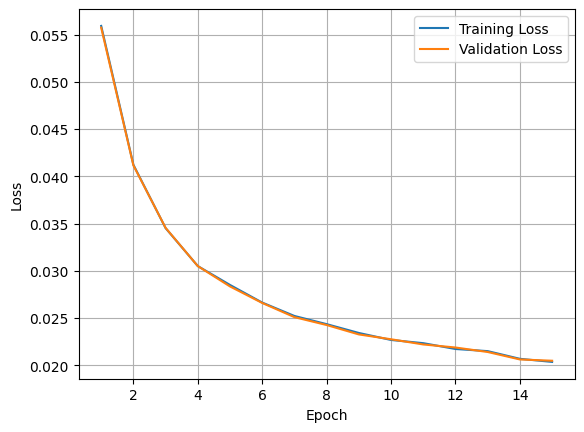

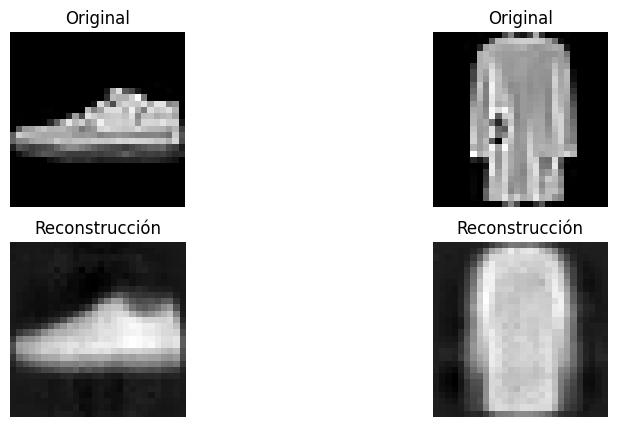

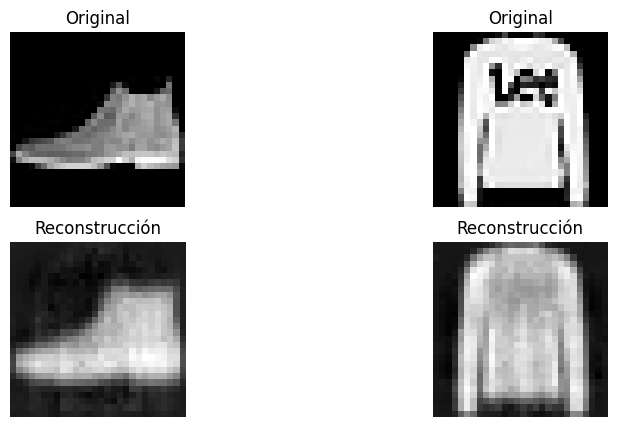

Error en conjunto de prueba para capa oculta 64: 0.2274


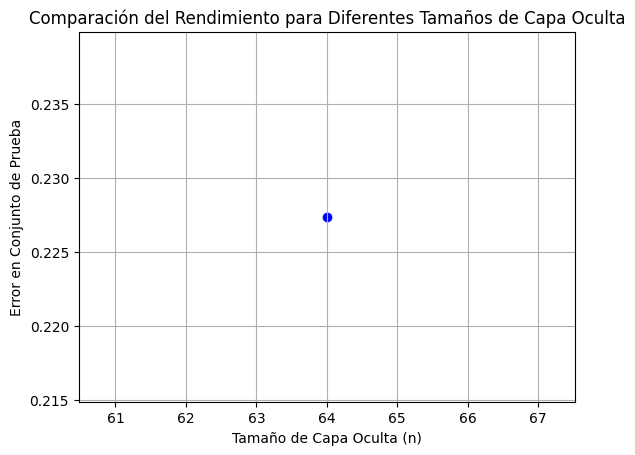

In [ ]:
# model = Autoencoder()

def test_autoencoder(autoencoder, test_loader, criterion):
    autoencoder.eval()
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)
            outputs = autoencoder(inputs)
            test_loss += criterion(outputs, inputs).item()

    average_test_loss = test_loss / len(test_loader)
    return average_test_loss

test_data = FashionMNIST("mnist-data", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

hidden_sizes = [64]

TRAIN_LOSSES = []
VAL_LOSSES   = []

test_losses = []


for hidden_size in hidden_sizes:
    print(f"\nEvaluando modelo con capa oculta de tamaño {hidden_size}\n")

    # Aca creo una instancia del modelo train
    train_losses, val_losses = train_autoencoder(hidden_size)
    TRAIN_LOSSES.append(train_losses)
    VAL_LOSSES.append(val_losses)

    # Utilizo el modelo entrenado en la fase de prueba
    autoencoder = Autoencoder(hidden_size)
    criterion = nn.MSELoss()
    test_loss = test_autoencoder(autoencoder, test_loader, criterion)
    test_losses.append(test_loss)

    print(f'Error en conjunto de prueba para capa oculta {hidden_size}: {test_loss:.4f}')

plt.scatter(hidden_sizes, test_losses, color='blue')
plt.xlabel('Tamaño de Capa Oculta (n)')
plt.ylabel('Error en Conjunto de Prueba')
plt.title('Comparación del Rendimiento para Diferentes Tamaños de Capa Oculta')
plt.grid()
plt.show()